## Optimal wind farm cable routing: Modeling branches and offshore transformer modules




Let G=(V,A),a complete and loop-free directed graph,V is a set of node that is partitioned into $(V_{t},V_{0},V_{s})$ and A is a set of edge that represents all possible connection between nodes.Each node can be a turbine, a steiner node or a substation. The set $V_t$ is a partition that contains all turbines available, the $V_0$ is the set of all substations and $V_s$ is the set of all Steiner nodes. The Steiner node is usefull when in the path there is a obstacle that must be avoided to continue with link. 

Every node has a power production that is denote as $P_{h}$, if the node is a turbine the $P_{h} \geq 0$, if it is a Steiner node the $P_{h} = 0$ instead for a substation the $P_{h} \geq -1$.

Let $T$ A node set that contains all different cable types that can be used. Each cable $t$ haS a capacity $k_t$ and a unit cost $u_t \geq 0$.The unit cost $u_t$ is usefull to calculate the $c^t_i,j = u_t * dist(i,j)$ that is the cost of each arc $(i,j) \in A$ covered by cable $t \in T$.


### Decision Variables

$$
x^t_{ij} = \begin{cases}
1 \text{ iff arc $(i, j)$ is constructed with cable type t $∈$ T} \\
0 \text { otherwise}
\end{cases}
$$


$$
y_{ij}= \{\text{indicate whether an arc $(i, j)$ is built with any type of cable. } (i,j)\}
$$

$$
f^k_{ij} = \{\text{representing the energy flow from i to j }\}
$$


### Constraints


\begin{alignat}{3}
\min \sum_{({i,j})  \in A} \sum_{t  \in T} c^t_{ij}x^t_{i,j} &&\\
\sum_{t \in T} x^t_{i,j} = y_{i,j} &&\;\;  {(i,j)} \in A\\
\sum_{i \in V : i \not= h} f_{h,i} - f_{i,h} = P_{h} &&\;\; h \in V_{t} \cup V_{s}\\
\sum_{t \in T} k_{t}x^t_{i,j} \geq f_{i,j} &&\;\;  {(i,j)} \in A\\
\sum_{j \in V : j \not= h} y_{h,j} = 1 &&\;\; h \in V_{t}\\
\sum_{j \in V : j \not= h} y_{h,j} = 0 &&\;\; h \in V_{t}\\
\sum_{j \in V : j \not= h} y_{h,j} \leq 1  &&\;\; h \in V_{s}\\
\sum_{i \in V : j \not= h} y_{i,h} \leq 1  &&\;\; h \in V_{s}\\
\sum_{i \in V : j \not= h} y_{i,h} \leq C  &&\;\; h \in V_{t}\\
 y_{i,j}+y_{j,i}+y_{h,k}+y_{k,h} \leq 1  &&\;\; \;\; \forall \text{ crossing segments (i,j) and (h,k)}\\
\end{alignat}

In [2]:
import networkx as nx
import gurobipy as gb
from itertools import combinations, chain
#import pygraphviz as pygv
import os
import matplotlib.pyplot as plt
import math
from IPython.display import SVG, display
import random
import numpy as np

In this box I generate a complete graph with 51 nodes and everyone has an attribute 'tp' that indicates the partition to which it belongs.
The list 'cables' represents all cable that can be used to connect nodes.

In [3]:
G = nx.Graph()
nodes=[]
cables=[{'type':"black", 'unit':393,'flow_max':24},
        {'type':"green", 'unit':460,'flow_max':32},
        {'type':"blue", 'unit':540,'flow_max':40}]

max_cable_subst=12 # max cable connected to substation
    
for i in range(0,51):
    if(i!=0 and i%2==0):
       G.add_node(i,tp=0) #Vt partizione delle turbine
    else:
        if(i==0):
            G.add_node(i,tp=-1) #V0 partizione per la substation
        else:
            G.add_node(i,tp=1) #Vs partizione per la substation
    for j in range(0,51):
            if j!=i:
                G.add_edge(i,j)               
G=G.to_directed()

In [4]:
print ("G has", G.number_of_nodes(), "nodes and", G.number_of_edges(), "edges")

G has 11 nodes and 110 edges


In this box I draw the graph with label to recognize the turbine, the Steiner node and the substation, respectively 'T', 'S' and 'Sbs'. 

I know the graph is puzzling but it is a similar example that the paper shows. 

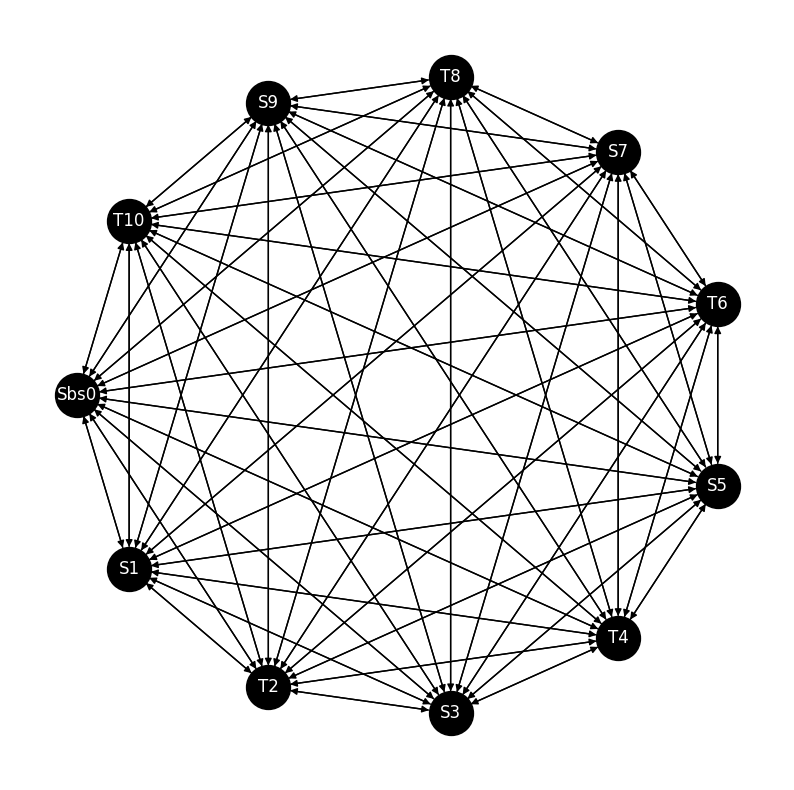

In [5]:
pos=nx.shell_layout(G)

node_lab={}
for i in G.nodes():
    if G.nodes[i]['tp'] == 1:
        node_lab[i]='S'+str(i)
    elif G.nodes[i]['tp'] == 0:
        node_lab[i]='T'+str(i)
    elif G.nodes[i]['tp'] == -1:
        node_lab[i]='Sbs'+str(i)

        
plt.figure(figsize=(10,10))

nx.draw_networkx_labels (G,pos, labels=node_lab,font_color='white')
nx.draw(G, pos, with_labels=False, node_color ='k', node_size=1000)

The function 'distanza' is a function that allow to calculate the Euclidean distance between two nodes. This function is used into formula of cost $c^{t}_{i,j}$ for objective function.

In [6]:
def distanza(P1, P2):
    from math import sqrt
    x1,y1=P1
    x2,y2=P2
    return sqrt((x1-x2)**2+(y1-y2)**2)

In this box I declared the variable for our model that are $x^t_{i,j}, y_{i,j}$ and $f_{i,j}$.

In [7]:
opt_wind_farm_c = gb.Model()

D=[] #type of cable for each edge

for i,j in G.edges():
    for cable in range(0,len(cables)):
       D.append((i,j,cable))
    
f = opt_wind_farm_c.addVars(G.edges(), \
                        lb=0.0,\
                        vtype=gb.GRB.CONTINUOUS,\
                        name='f')

y=opt_wind_farm_c.addVars(G.edges(), \
                        lb=0.0,\
                        ub=1.0,\
                        vtype=gb.GRB.BINARY,\
                        name='y')

x= opt_wind_farm_c.addVars(D, \
                        lb=0.0, \
                        ub=1.0, \
                        obj=[cable['unit']*distanza(pos[i],pos[j]) for i,j in G.edges() for cable in cables],\
                        vtype=gb.GRB.BINARY,\
                        name='x')


opt_wind_farm_c.update()
opt_wind_farm_c.write('opt_wind_farm_c.lp')

Restricted license - for non-production use only - expires 2024-10-28


Here, I insert in the our model the constraints that constrain the use of a cable for each built arc.

In [8]:
for i,j in G.edges():
    sum_for_cable=gb.quicksum(x[i,j,cable] for cable in range(0,len(cables)))
    opt_wind_farm_c.addConstr((sum_for_cable == y[i,j]), name="2Constraints")
    
opt_wind_farm_c.update()
opt_wind_farm_c.write('opt_wind_farm_c.lp')

These constraints say that the flow of energy entering in each node of $V_{t}$ and $V_{s}$ partitions is equal to energy exiting plus the power production of that node.

In [9]:
for h in G.nodes():
    if (G.nodes[h]['tp']) == 0:
        opt_wind_farm_c.addConstr(f.sum(h,'*') - f.sum('*',h) == 8, name="3Constraints")
    elif G.nodes[h]['tp'] == 1:
            opt_wind_farm_c.addConstr(f.sum(h,'*') - f.sum('*',h) == 0, name="3Constraints")

opt_wind_farm_c.update()
opt_wind_farm_c.write('opt_wind_farm_c.lp')

Here, the constraints ensure that the flow ${f_{i,j}}$ does not exceed the capacity $k_{t}$ of the cable $t$.

In [10]:
for i,j in G.edges():
    sum_for_cable=gb.quicksum(cables[cable]["flow_max"]*x[i,j,cable] for cable in range(0,len(cables)))
    opt_wind_farm_c.addConstr((sum_for_cable >= f[i,j]), name="4Constraints")
opt_wind_farm_c.update()

opt_wind_farm_c.write('opt_wind_farm_c.lp')

These constraints impose that only one cable leaves a turbine.

In [11]:
opt_wind_farm_c.addConstrs((y.sum(h,'*') == 1
                         for h in G.nodes() 
                         if G.nodes[h]['tp'] == 0  ), name="5Constraints")



opt_wind_farm_c.update()

opt_wind_farm_c.write('opt_wind_farm_c.lp')

Here, the constraints say that the substation has no cable exiting.

In [12]:
opt_wind_farm_c.addConstrs((y.sum(h,'*') == 0 
                         for h in G.nodes()
                         if G.nodes[h]['tp'] == -1 ), name="6Constraints")

opt_wind_farm_c.update()

opt_wind_farm_c.write('opt_wind_farm_c.lp')

The constraints 7 and 8 say that the Steiner nodes is optional to connect them but if they are connected, only one cable can enter and can exit from/to these nodes.

In [13]:
opt_wind_farm_c.addConstrs((y.sum(h,'*') <= 1 
                         for h in G.nodes() 
                         if G.nodes[h]['tp'] == 1  ), name="7Constraints")

opt_wind_farm_c.update()

opt_wind_farm_c.write('opt_wind_farm_c.lp')

In [14]:
opt_wind_farm_c.addConstrs((y.sum('*',h) <= 1
                         for h in G.nodes() 
                         if G.nodes[h]['tp'] == 1 ), name="8Constraints")

opt_wind_farm_c.update()

opt_wind_farm_c.write('opt_wind_farm_c.lp')

These constraints impose that each substation can have the maximum number of cable can enter.

In [15]:
opt_wind_farm_c.addConstrs((y.sum('*',h) <= max_cable_subst
                         for h in G.nodes() 
                         if G.nodes[h]['tp'] == -1 ), name="9Constraints")

opt_wind_farm_c.update()

opt_wind_farm_c.write('opt_wind_farm_c.lp')

These function is used to find the intersection between two arc. It is usefull for next constraints.

In [16]:
def ccw(A,B,C):
    return (C[1]-A[1]) * (B[0]-A[0]) > (B[1]-A[1]) * (C[0]-A[0])

# Return true if line segments AB and CD intersect
def intersect(A,B,C,D):
    return ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D)

In [17]:
collisions=[]
for i,j in G.edges():
    for k,h in G.edges():
        if (k!=i and h!=j and k!=j and h!=i):
            if(intersect(pos[i],pos[j],pos[k],pos[h])):
                collisions.append([(i,j),(k,h)])

The last box contain the constraints that say if there are two crossing arcs, only one can be built.

In [18]:
for cross in collisions:
    opt_wind_farm_c.addConstr((y[cross[0]]+y[cross[1]]+y[(cross[0][1],cross[0][0])]+y[(cross[1][1],cross[1][0])]<= 1), name="10Constraints")

opt_wind_farm_c.update()

opt_wind_farm_c.write('opt_wind_farm_c.lp')

In [19]:
opt_wind_farm_c.optimize()

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i7-8550U CPU @ 1.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads



GurobiError: Model too large for size-limited license; visit https://www.gurobi.com/free-trial for a full license

The next three box there are the code for building the graph of solution.
I have copied the initially graph and I deleted all the nodes and arcs that don't belong to solution found.

In [ ]:
S=G.copy()
clean2=[]
good_edge=[]
for v in opt_wind_farm_c.getVars():
    if v.x > 0:
        #print ('%s=%g' % (v.varName, v.x), end = ' ')
        if v.varName.startswith('y'):
            clean=v.varName.replace('y[','').replace(']','').split(',')
            good_edge.append((eval(clean[0]),eval(clean[1])))
            for i in clean:
                clean2.append(eval(i))
node_delete=[]
edge_delete=[]
for j in G.nodes():
    if j not in clean2:
        clean.append(j)
for i in G.edges():
    if i not in good_edge:
        edge_delete.append(i)
        
S.remove_nodes_from(clean)
S.remove_edges_from(edge_delete)

In [ ]:
activated_edge_black=[]
activated_edge_green=[]
activated_edge_blue=[]

for i,j in S.edges():
    for cable in range(0,len(cables)):
        if x[i,j,cable].x > 0 and cables[cable]['type'] == 'black':
            activated_edge_black.append((i,j))
        elif x[i,j,cable].x > 0 and cables[cable]['type'] == 'green':
            activated_edge_green.append((i,j))
        elif x[i,j,cable].x > 0 and cables[cable]['type'] == 'blue':
            activated_edge_blue.append((i,j))
        if x[i,j,cable].x > 0:
            if S.nodes[i]['tp'] == 1:
                node_lab[i]='S'+str(i)
            elif S.nodes[i]['tp'] == 0:
                node_lab[i]='T'+str(i)
            elif S.nodes[i]['tp'] == -1:
                node_lab[i]='Sbs'+str(i)    

The color of each arch indicates the type of cable used to connect the nodes.

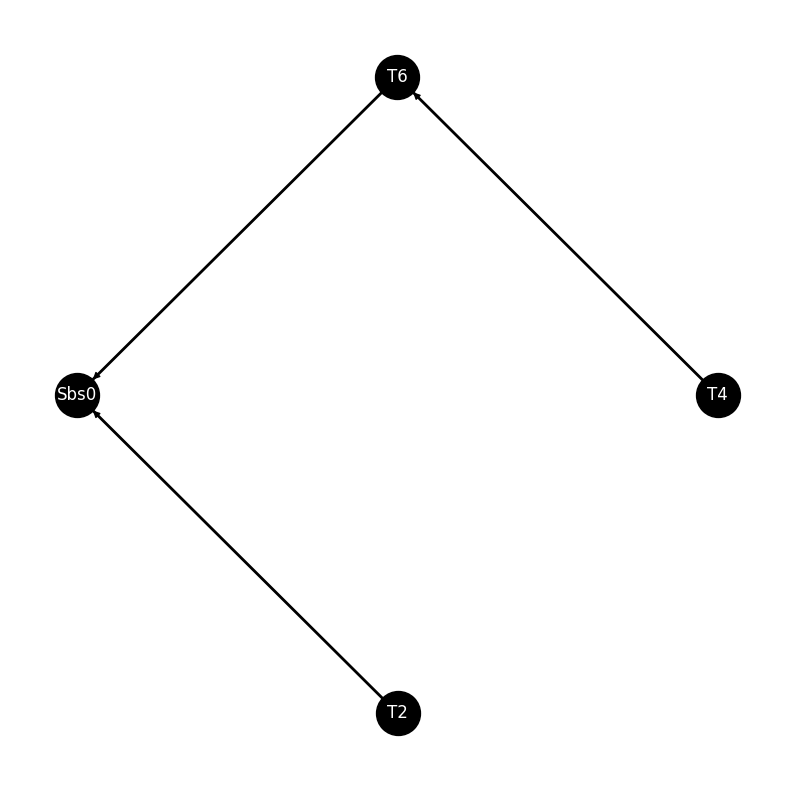

In [ ]:
node_lab={}
for i in S.nodes():
    if S.nodes[i]['tp'] == 1:
        node_lab[i]='S'+str(i)
    elif S.nodes[i]['tp'] == 0:
        node_lab[i]='T'+str(i)
    elif S.nodes[i]['tp'] == -1:
        node_lab[i]='Sbs'+str(i)

pos=nx.shell_layout(S)
 
plt.figure(figsize=(10,10))

nx.draw_networkx_edges (S, pos,edgelist=activated_edge_black, edge_color='black',width=2)
nx.draw_networkx_edges (S, pos,edgelist=activated_edge_green, edge_color='r',width=7)
nx.draw_networkx_edges (S, pos,edgelist=activated_edge_blue, edge_color='b',width=7)

nx.draw_networkx_labels (S,pos, labels=node_lab,font_color='white')
nx.draw(S, pos, node_color ='k', node_size=1000)